<a href="https://colab.research.google.com/github/Fathimath-Rifna-VK/fmml2021/blob/main/Module_10_FMML_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to pytorch

In this lab, we go over the basics of [pytorch](https://pytorch.org/), an open source ML framework  

In [ ]:
import numpy as np

# the module is named `torch`
import torch

## Tensors

At its core, PyTorch is a library for processing tensors.  
A tensor is a number, vector, matrix, or any n-dimensional array. It is equivalent to an `np.ndarray`  

In [ ]:
def show_tensor(t):
    print("dtype:", t.dtype)
    print("size:", t.size())
    print(t)

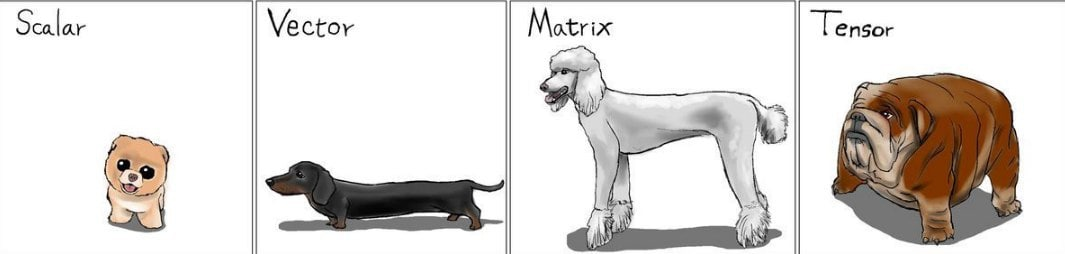

In [ ]:
# Number
t0 = torch.tensor(4)
show_tensor(t0)

In [ ]:
# Vector
t1 = torch.tensor([1.0, 2.0, 3.0, 4.0])
show_tensor(t1)

Notice that torch used 64 bits for integer and 32 bits for float by default

In [ ]:
# Matrix
t2 = torch.tensor(
    [
        [1.0, 2.0, 3.0],
        [4.0, 5.0, 6.0],
        [7.0, 8.0, 9.0],
    ]
)
show_tensor(t2)

In [ ]:
# 3d array
t3 = torch.tensor(
    [
        [[1, 2], [3, 4]],
        [[5, 6], [7, 8]],
    ]
)
show_tensor(t3)

Like numpy, torch expects it's tensors to be of regular shape

In [ ]:
t4 = torch.tensor(
    [
        [1, 2],
        [3, 4],
        [5],
    ]
)
show_tensor(t4)

## Interoperability with numpy

You can easily convert between a torch tensor and a numpy nd array

In [ ]:
t5 = torch.tensor([[1, 2], [3, 4]])
# call .numpy() to convert a tensor to np array
a5 = t5.numpy()

print("type:", type(a5))
print("dtype:", a5.dtype)
print(a5)

In [ ]:
# use torch.from_numpy to go from np array to tensor
t6 = torch.from_numpy(a5)
show_tensor(t6)

Just like numpy, you can index into tensors using the same notation

In [ ]:
print(t2)
print()
print(t2[:, 1])

## Torch gradients

Torch tensors are capable of tracking gradients

In [ ]:
# create tensors.
x = torch.tensor(3.0)
w = torch.tensor(4.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)
print(x, w, b, sep="\n")

Lets take this simple function:
$y = wx + b$

now,
\begin{align}\frac{\partial y}{\partial w} = x\end{align}
and
\begin{align}\frac{\partial y}{\partial b} = 1\end{align}

In [ ]:
y = w * x + b
print(y)

Torch is capable of tracking that we got y after multiplying w, x and then adding b  
It uses this information while calculating the partial differential of y wrt w and b

Note that x wasn't marked with requires_grad and hence it doesn't exist

In [ ]:
# compute derivatives
y.backward()

In [ ]:
# display gradients
print("dy/dx:", x.grad)  # shouldn't exist since x wasn't marked with requires_grad
print("dy/dw:", w.grad)  # should be equal to x
print("dy/db:", b.grad)  # should be 1

## Differentiation in Autograd
Let's take a look at how `autograd` collects gradients. We create two tensors `a` and `b` with `requires_grad=True`. This signals to `autograd` that every operation on them should be tracked.

In [ ]:
a = torch.tensor([2.0, 3.0], requires_grad=True)
b = torch.tensor([6.0, 4.0], requires_grad=True)

Now, let's take the function
$Q=3a^3−b^2$

In [ ]:
Q = (3 * a ** 3) - (b ** 2)

Let's assume `a` and `b` to be parameters of an NN, and `Q` to be the error. In NN training, we want gradients of the error w.r.t. parameters, i.e.

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}
\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}


When we call `.backward()` on `Q`, autograd calculates these gradients and stores them in the respective tensors' `.grad` attribute.

We need to explicitly pass a `gradient` argument in `Q.backward()` because it is a vector. `gradient` is a tensor of the same shape as `Q`, and it represents the gradient of Q w.r.t. itself, i.e.

\begin{align}\frac{dQ}{dQ} = 1\end{align}

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like `Q.sum().backward()`.

In [ ]:
external_grad = torch.tensor([1.0, 1.0])
Q.backward(gradient=external_grad)

Gradients are now deposited in `a.grad` and `b.grad`

In [ ]:
# check if collected gradients are correct
print(9 * a ** 2 == a.grad)
print(-2 * b == b.grad)

In [ ]:
print(a.grad, b.grad, sep="\n")

## Visualizing the computation graph

We use the module [pytorchviz](https://github.com/szagoruyko/pytorchviz) for this

In [ ]:
!pip install -q torchviz
from torchviz import make_dot

In [ ]:
make_dot(Q, params={"Q": Q, "a": a, "b": b})

## Detaching from the computation graph

Sometimes, we need to just get the value and do some operations on it without caring about gradients. For doing this, we can call `.detach()`  on the tensor.

This gives us another tensor that doesn't exist on the computation graph and doesn't require gradients

Note that the original tensor remains untouched

In [ ]:
print("Original")
print(Q)

print("---")
print("Detached")
# Q_detached won't live on the computation graph
Q_detached = Q.detach()
print(Q_detached)

print("---")
print("Original after detach")
# Q will not be affected by this operation
print(Q)

## `torch.no_grad`

Torch gives us a context manager which can disable gradient globally! This is really helpful when we are doing inference for example, we don't want to track gradients or update them.

`torch.no_grad` and `detach` are not the same though.

> tensor.detach() creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.  
The wrapper with torch.no_grad() temporarily set all the requires_grad flag to false. torch.no_grad says that no operation should build the graph.  
The difference is that one refers to only a given variable on which it is called. The other affects all operations taking place within the with statement. Also, torch.no_grad will use less memory because it knows from the beginning that no gradients are needed so it doesn’t need to keep intermediary results.
[[source]](https://stackoverflow.com/a/56817594)

In [ ]:
with torch.no_grad():
    # we still have the gradient function for the old variable
    print(Q)

    # try doing the same thing we did above
    # but now we have no_grad
    Q = (3 * a ** 3) - (b ** 2)
    Q.backward(gradient=external_grad)

# Resources
- https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html
- https://pytorch.org/docs/stable/generated/torch.no_grad.html
- https://stackoverflow.com/a/56817594
- https://discuss.pytorch.org/t/detach-no-grad-and-requires-grad/16915/10

be more explicit, give 1-1 math relations